In [1]:
#Estimation of reaction rates of bacterial serotonin production from published data, park et al, 2014
#E.coli concentration at OD600=8e8 cells/ml, 
#initial concentration of tryptophan: 3 mM
#initial concentration of serotonin: 0 mM

#Assume 1st order, irreversible reaction (enzymatic, at low concentrations can assume non-MM) 
#Two step reaction, with one rate limiting step, will assume one reaction rate for overall reaction: A -> B -> C

In [5]:
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

timesRXN = numpy.array([0.0, 3.0, 6.0, 9.0, 12., 15., 24.]) #hours
serConcRXN = numpy.array([0.0, 0.055612, 0.124844, 0.147543, 0.173079, 0.181591, 0.209965]) #mM
trpConcRXN = 3.0 - serConcRXN #mM




Parameter 0: 0.003924757968610744 +/- 0.0004521307226862496 (1 st. dev.)


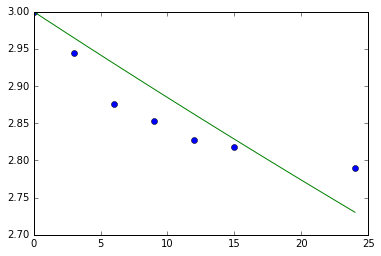

In [6]:
import scipy.optimize

def RXNfunction(t,k):
    "First order, irreversible reaction to approximate conversion of tryptophan to serotonin"
    #ln(ca/cao)=-kt
    #units k, 1/h
    cao=3 #mmol/L
    return numpy.exp(-1.0*k*t)*cao


#from dr west's regression assignment for class
optimal_parameters, covariance = scipy.optimize.curve_fit(RXNfunction, timesRXN, trpConcRXN)

def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = numpy.sqrt(numpy.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))


# This should end up with your optimized parameters
##optimized_parameters = ParameterSet(0,0,0,0)
report(optimal_parameters, covariance)

# Plot the data
plt.plot(timesRXN, trpConcRXN, 'o', label='data')

    # Make a new x array with 50 points for smoother lines
x_many_points = numpy.linspace(timesRXN.min(),timesRXN.max(),50)
    # Plot the fitted curve
plt.plot(x_many_points, RXNfunction(x_many_points, *optimal_parameters), label='fitted')
    
plt.show()

In [4]:
#above assumes a concentration of 8e8 bacteria per mL
#Based on average intestinal (small and large) volume of 130 mL
#and total microbes in the body, 10^14, concentrations could be high as 10^14/130 per mL
#but not all produce serotonin

serProdMicrobeMax = 10e14/130 #bacteria per mL
serProdMicrobeMin = serProdMicrobeMax*0.000001


#Adjustments to k value based on bacterial concentration 
#serConcRXNMin = (serProdMicrobeMin/8e8)*serConcRXN
#trpConcRXNMin = 3.0 - serConcRXNMin
#serConcRXNMax = (serProdMicrobeMax/8e8)*serConcRXN
#trpConcRXNMax = 3.0 - serConcRXNMax

#does not account for change in RATE how to account for differences based on differences in number of bacteria from this data?


optimal_parametersMin, covarianceMin = scipy.optimize.curve_fit(RXNfunction, timesRXN, trpConcRXNMin)
optimal_parametersMax, covarianceMax = scipy.optimize.curve_fit(RXNfunction, timesRXN, trpConcRXNMax)

report(optimal_parametersMin, covarianceMin)
report(optimal_parametersMax, covarianceMax)

plt.plot(timesRXN, trpConcRXNMin)
plt.plot(timesRXN, trpConcRXNMax)
plt.plot(x_many_points, RXNfunction(x_many_points, *optimal_parametersMin), label='fitted')
plt.plot(x_many_points, RXNfunction(x_many_points, *optimal_parametersMax), label='fitted')
    
plt.show()
    


NameError: name 'trpConcRXNMin' is not defined